In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import geemap, ee

import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

In [3]:
%load_ext autoreload
%autoreload 2
import sys  
sys.path.insert(0, '../lib/')


In [4]:
%reload_ext autoreload
import sand_classification as sc
import quality_mosaic as qm
import train_val as tv

# Train Classifier

In [5]:
#RF, _ = tv.load_train_rf('../data/labels/gt-bands.xlsx', num_trees=1000, rf_type='sklearn')
# RF = tv.get_rf_from_gee('RF_sklearn_n400_d200_msl1_mss3')
RF = tv.get_rf_from_gee('RF_sklearn_seg15_n1133_d50_msl4_mss2_mf-None_bTrue')

#### Load Image for Validation

In [6]:
roi = ee.FeatureCollection('projects/gee-sand/assets/ganga_gst_aoi')
upper = ee.FeatureCollection('projects/gee-sand/assets/ganga_gst_upper_aoi')
lower = ee.FeatureCollection('projects/gee-sand/assets/ganga_gst_lower_aoi')
gst = ee.FeatureCollection('projects/gee-sand/assets/ganga_gst_region')


In [7]:
date = '2022-12-07' #from analysis in river_sand_flooding_gst_ganga GEE 
max_search_window_months = 2
median_samples = 5
mosaic_method = 'median'

lon, lat = 78.19376654, 29.74481053
gst_pt = ee.Geometry.Point([lon, lat])

mining_centroids = ee.FeatureCollection('projects/gee-sand/assets/bihar_sand_banks_centroids')

s1_s2 = qm.get_s1_s2(roi=roi, date=date, max_search_window_months=max_search_window_months,median_samples=median_samples, mosaic_method=mosaic_method, clip=False)
s1_s2.bandNames()
roi

Search window from 2022-10-07 to 2023-02-07


#### SNIC

In [8]:
Map = geemap.Map()
Map.centerObject(roi, 10)
Map.add_basemap('SATELLITE')
# Map.add_basemap('Stamen.Toner')
Map.addLayer(s1_s2, qm.visParamsVV, 'S1', False)
Map.addLayer(s1_s2, qm.visParamsMTGSI , 'mTGSI', False)
Map.addLayer(s1_s2, qm.visParamsRGB, 'S2')


Map

Map(center=[29.69879481189179, 78.13664798282139], controls=(WidgetControl(options=['position', 'transparent_b…

In [9]:
snicBands = tv.apply_snic(image=s1_s2, roi=roi, size_segmentation=10, Map=Map)
classy_RF = snicBands.classify(RF)
#necessary to keep the final resolution at 10m: not needed if you're zooming around and using interactively
# classy_RF = classy_RF.reproject (crs = classy_RF.projection (), scale = 10)

# classy_RF.getInfo()

Map.addLayer(
    classy_RF,
    tv.classy_vizParams,
    'classification',
)

# Map.add_legend(title="Classes", legend_dict=tv.legend_dict, position="bottomright")




In [12]:
# add only the sand and gravel classes to the map and keep all other classes transparent
sand_gravel = classy_RF.updateMask(classy_RF.eq(1).Or(classy_RF.eq(2)))
# sand_gravel = classy_RF.updateMask(classy_RF.eq(2))
Map.addLayer(sand_gravel, tv.classy_vizParams, 'sand_gravel')

### Add zones and mining locations to map

In [13]:
#Create the outline of the upper section
region_styles = [ {'palette': 'a2a2d0'},  {'palette': 'ff6347'}, {'palette': '00008b'}]

empty = ee.Image().byte()
outline1 = empty.paint(featureCollection = upper,
  color= 1,
  width= 1.5)
style1 =  region_styles[0]
Map.addLayer(outline1,style1, 'GST Upriver')

#Create the outline of the GST section
empty = ee.Image().byte()
outline3 = empty.paint(featureCollection = gst,
  color= 1,
  width= 1.5)
style2 = region_styles[1]
Map.addLayer(outline3, style2, 'GST')

#Create the outline of the lower section
empty = ee.Image().byte()
outline2 = empty.paint(featureCollection = lower,
  color= 1,
  width= 1.5)
style3 = region_styles[2]
Map.addLayer(outline2, style3, 'GST Downriver')

# 




Map.addLayer(gst_pt, {'color':'red', 'size':20},'GST Point Sample')

Map.addLayer(mining_centroids, {'color':'blue'}, 'Mining Centroids')

## Masks

In [13]:
mask_sand = classy_RF.remap([0,2,3,4,5,6,7], [0,2,3,4,5,6,7])
mask_gravel = classy_RF.remap([0,1,3,4,5,6,7], [0,1,3,4,5,6,7])

Map.addLayer(mask_sand, {"palette": 'black'},
             '[mask]Sand');
Map.addLayer(mask_gravel, {"palette": 'black'},
             '[mask]Gravel');

## Statistics

A. For classification outputs

In [15]:
#UPPER
sand_only = classy_RF.eq(1)
sand_only_count_upper = sand_only.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=upper,
    scale=10,
    maxPixels=1e9,
    tileScale=10,
)

sand_only_count_upper = sand_only_count_upper.getInfo()['classification']

gravel_only = classy_RF.eq(2)
gravel_only_count_upper = gravel_only.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=upper,
    scale=10,
    maxPixels=1e9,
    tileScale=10,
)
gravel_only_count_upper = gravel_only_count_upper.getInfo()['classification']
s_to_g_ratio_upper = sand_only_count_upper/gravel_only_count_upper
print("Upper s/g ratio: ", s_to_g_ratio_upper)

## GST
sand_only_count_gst = sand_only.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=gst,
    scale=10,
    maxPixels=1e9,
    tileScale=10,
)

gravel_only_count_gst = gravel_only.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=gst,
    scale=10,
    maxPixels=1e9,
    tileScale=10,
)

sand_only_count_gst   = sand_only_count_gst.getInfo()['classification']
gravel_only_count_gst = gravel_only_count_gst.getInfo()['classification']

s_to_g_ratio_gst = sand_only_count_gst/gravel_only_count_gst
print("GST s/g ratio: ", s_to_g_ratio_gst)

#LOWER
sand_only_count_lower = sand_only.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=lower,
    scale=10,
    maxPixels=1e9,
    tileScale=10,
)

gravel_only_count_lower = gravel_only.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=lower,
    scale=10,
    maxPixels=1e9,
    tileScale=10,
)

sand_only_count_lower   = sand_only_count_lower.getInfo()['classification']
gravel_only_count_lower = gravel_only_count_lower.getInfo()['classification']

s_to_g_ratio_lower = sand_only_count_lower/gravel_only_count_lower
print("Lower s/g ratio: ", s_to_g_ratio_lower)



print(s_to_g_ratio_upper, s_to_g_ratio_gst,s_to_g_ratio_lower)

Upper s/g ratio:  0.7152970935242807
GST s/g ratio:  8.443758562985659
Lower s/g ratio:  9.612125385975183
0.7152970935242807 8.443758562985659 9.612125385975183


# Publication Quality Maps

In [10]:
from geemap import cartoee
import cartopy.crs as ccrs

Increase the bounding box by 10kms

In [ ]:
#.buffer(20).getInfo()['coordinates'][0]
bbox = roi.geometry().bounds().buffer(1000).bounds() #.getInfo()['coordinates'][0]
bbox

In [11]:
#get the bounding box of the roi
bbox = roi.geometry().bounds().buffer(1000).bounds().getInfo()['coordinates'][0]
bbox = [bbox[0][0], bbox[0][1], bbox[2][0], bbox[2][1]] #snce you only need the corners
bbox

[78.0116170852459, 29.307140146460124, 78.40787644440195, 30.148086111932628]

## Download GeoTIFFs

### Tile exports of regions to reduce memory loads

In [16]:
# fishnet = geemap.fishnet(roi,rows=5,columns=2, intersect=True, buffer=0)
fishnet = geemap.fishnet(roi,h_interval=0.005, v_interval=0.005, intersect=True, delta=0)
Map.addLayer(fishnet, {}, 'fishnet')
fishnet

In [29]:
classy_RF_10m = classy_RF.reproject (crs = classy_RF.projection(), scale = 10)

classesM = classy_RF_10m.visualize(**tv.classy_vizParams)
geemap.download_ee_image_tiles(classesM,
                               fishnet,
                               out_dir='../data/validation/Ganga-GST/classes/',
                               prefix='Ganga_tiles_classes_',
                               scale=10)

# sg = classy_RF_10m.updateMask(classy_RF.eq(1).Or(classy_RF.eq(2)))
# sgM = sg.visualize(**tv.classy_vizParams)

s = classy_RF_10m.updateMask(classy_RF.eq(1))
sM = s.visualize(**tv.classy_vizParams)

# geemap.download_ee_image_tiles(sM,
#                                fishnet,
#                                out_dir='../data/validation/Ganga-GST/s/',
#                                prefix='Ganga_tiles_s_',
#                                scale=10)


g = classy_RF_10m.updateMask(classy_RF.eq(2))
gM = g.visualize(**tv.classy_vizParams)
geemap.download_ee_image_tiles(gM,
                               fishnet,
                               out_dir='../data/validation/Ganga-GST/g/',
                               prefix='Ganga_tiles_g_',
                               scale=10)

Ganga_tiles_classes_01.tif: |          | 0.00/932k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_02.tif: |          | 0.00/934k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_03.tif: |          | 0.00/931k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_04.tif: |          | 0.00/932k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_05.tif: |          | 0.00/932k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_06.tif: |          | 0.00/931k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_07.tif: |          | 0.00/932k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_08.tif: |          | 0.00/934k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_09.tif: |          | 0.00/931k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_10.tif: |          | 0.00/932k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_11.tif: |          | 0.00/931k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_12.tif: |          | 0.00/932k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_13.tif: |          | 0.00/934k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_14.tif: |          | 0.00/934k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_15.tif: |          | 0.00/931k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_16.tif: |          | 0.00/932k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_17.tif: |          | 0.00/932k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_18.tif: |          | 0.00/934k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_19.tif: |          | 0.00/931k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_20.tif: |          | 0.00/932k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_21.tif: |          | 0.00/932k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_22.tif: |          | 0.00/934k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_23.tif: |          | 0.00/934k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_24.tif: |          | 0.00/934k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_25.tif: |          | 0.00/932k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_26.tif: |          | 0.00/931k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_27.tif: |          | 0.00/932k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_28.tif: |          | 0.00/934k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_29.tif: |          | 0.00/932k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_30.tif: |          | 0.00/931k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_31.tif: |          | 0.00/932k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_classes_32.tif: |          | 0.00/931k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_01.tif: |          | 0.00/932k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_02.tif: |          | 0.00/934k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_03.tif: |          | 0.00/931k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_04.tif: |          | 0.00/932k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_05.tif: |          | 0.00/932k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_06.tif: |          | 0.00/931k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_07.tif: |          | 0.00/932k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_08.tif: |          | 0.00/934k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_09.tif: |          | 0.00/931k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_10.tif: |          | 0.00/932k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_11.tif: |          | 0.00/931k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_12.tif: |          | 0.00/932k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_13.tif: |          | 0.00/934k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_14.tif: |          | 0.00/934k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_15.tif: |          | 0.00/931k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_16.tif: |          | 0.00/932k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_17.tif: |          | 0.00/932k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_18.tif: |          | 0.00/934k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_19.tif: |          | 0.00/931k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_20.tif: |          | 0.00/932k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_21.tif: |          | 0.00/932k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_22.tif: |          | 0.00/934k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_23.tif: |          | 0.00/934k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_24.tif: |          | 0.00/934k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_25.tif: |          | 0.00/932k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_26.tif: |          | 0.00/931k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_27.tif: |          | 0.00/932k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_28.tif: |          | 0.00/934k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_29.tif: |          | 0.00/932k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_30.tif: |          | 0.00/931k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_31.tif: |          | 0.00/932k (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_tiles_g_32.tif: |          | 0.00/931k (raw) [  0.0%] in 00:00 (eta:     ?)

In [21]:
fishnet_base = geemap.fishnet(roi,h_interval=0.1, v_interval=0.1, intersect=True, buffer=0.01)
Map.addLayer(fishnet_base, {}, 'fishnet')
fishnet_base

### Download the S-2 Basemap

In [26]:
bbox = roi.geometry().bounds().buffer(1000).bounds() #.getInfo()['coordinates'][0]
# bbox = [bbox[0][0], bbox[0][1], bbox[2][0], bbox[2][1]] #snce you only need the corners

fishnet_base = geemap.fishnet(bbox,h_interval=0.1, v_interval=0.08, intersect=True, buffer=0.005)
Map.addLayer(fishnet_base, {}, 'fishnet')

baseM = s1_s2.reproject(crs = s1_s2.projection(), scale = 10).visualize(**qm.visParamsRGB)

geemap.download_ee_image_tiles(baseM,
                               fishnet_base,
                               out_dir='../data/validation/Ganga-GST/base/',
                               prefix='Ganga_base_tiles_',
                               scale=10)

# for i, r in enumerate([upper, gst, lower]):
    
#     outline = empty.paint(featureCollection = r,
#                             color= 1,
#                             width= 2)
#     style = region_styles[i]
#     baseM = baseM.blend(outline.visualize(**style))

# filename = '../data/validation/Ganga-GST/Ganga_GST_base.tif'
# geemap.download_ee_image(image=baseM, region=bbox, filename=filename, scale=10)

Ganga_base_tiles_01.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_02.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_03.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_04.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_05.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_06.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_07.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_08.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_09.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_10.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_11.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_12.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_13.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_14.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_15.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_16.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_17.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_18.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_19.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_20.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_21.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_22.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_23.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_24.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_25.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_26.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_27.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_28.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_29.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_30.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_31.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_32.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_33.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_34.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_35.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_36.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_37.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_38.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_39.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_40.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_41.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_42.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_43.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

Ganga_base_tiles_44.tif: |          | 0.00/2.98M (raw) [  0.0%] in 00:00 (eta:     ?)

### Download partitioning into Sections

Note, this process gives inaccurate results: for some reason GEE does not render the classes/SG classes correctly. Please use the fishnet method above. This is only for reference

In [22]:

sand_palette = {"min": 0, "max": 1, "palette": 'f3ff4a'}
gravel_palette = {"min": 0, "max": 1, "palette": 'ffa500'}

for i, r in enumerate([upper, gst, lower]):
    bbox = r.geometry().bounds().getInfo()['coordinates'][0]
    bbox = [bbox[0][0], bbox[0][1], bbox[2][0], bbox[2][1]] #since you only need the corners
    classy_region = classy_RF.clip(r).reproject (crs = classy_RF.projection(), scale = 10)

    s_RF = classy_region.updateMask(classy_RF.eq(1))
    classesM = s_RF.visualize(**sand_palette)

    g_RF = classy_region.updateMask(classy_RF.eq(2))
    classesM = classesM.blend(g_RF.visualize(**gravel_palette))
    # classesM = g_RF.visualize(**gravel_palette)
    
    outline = empty.paint(featureCollection = r,
                            color= 1,
                            width= 2)
    style = region_styles[i]
    blendM = classesM.blend(outline.visualize(**style))

    filename = 'ganga_section_' + str(i) + '.tif'
    geemap.download_ee_image(image=blendM, region=bbox, filename=filename, scale=10)

ganga_section_0.tif: |          | 0.00/41.8M (raw) [  0.0%] in 00:00 (eta:     ?)

OSError: Error downloading tile: Output of image computation is too large (12 bands for 3485696 pixels = 159.6 MiB > 80.0 MiB).
If this is a reduction, try specifying a larger 'tileScale' parameter.

In [ ]:
rr = classesM.reduceRegion(
  reducer=ee.Reducer.mean(),
  geometry=lower.geometry(),
#   crs= 'EPSG:4326',
  maxPixels= 1e9,)
#   crsTransform= 'affine',)
rr.getInfo()

## Render Maps

In [29]:
from matplotlib.lines import Line2D

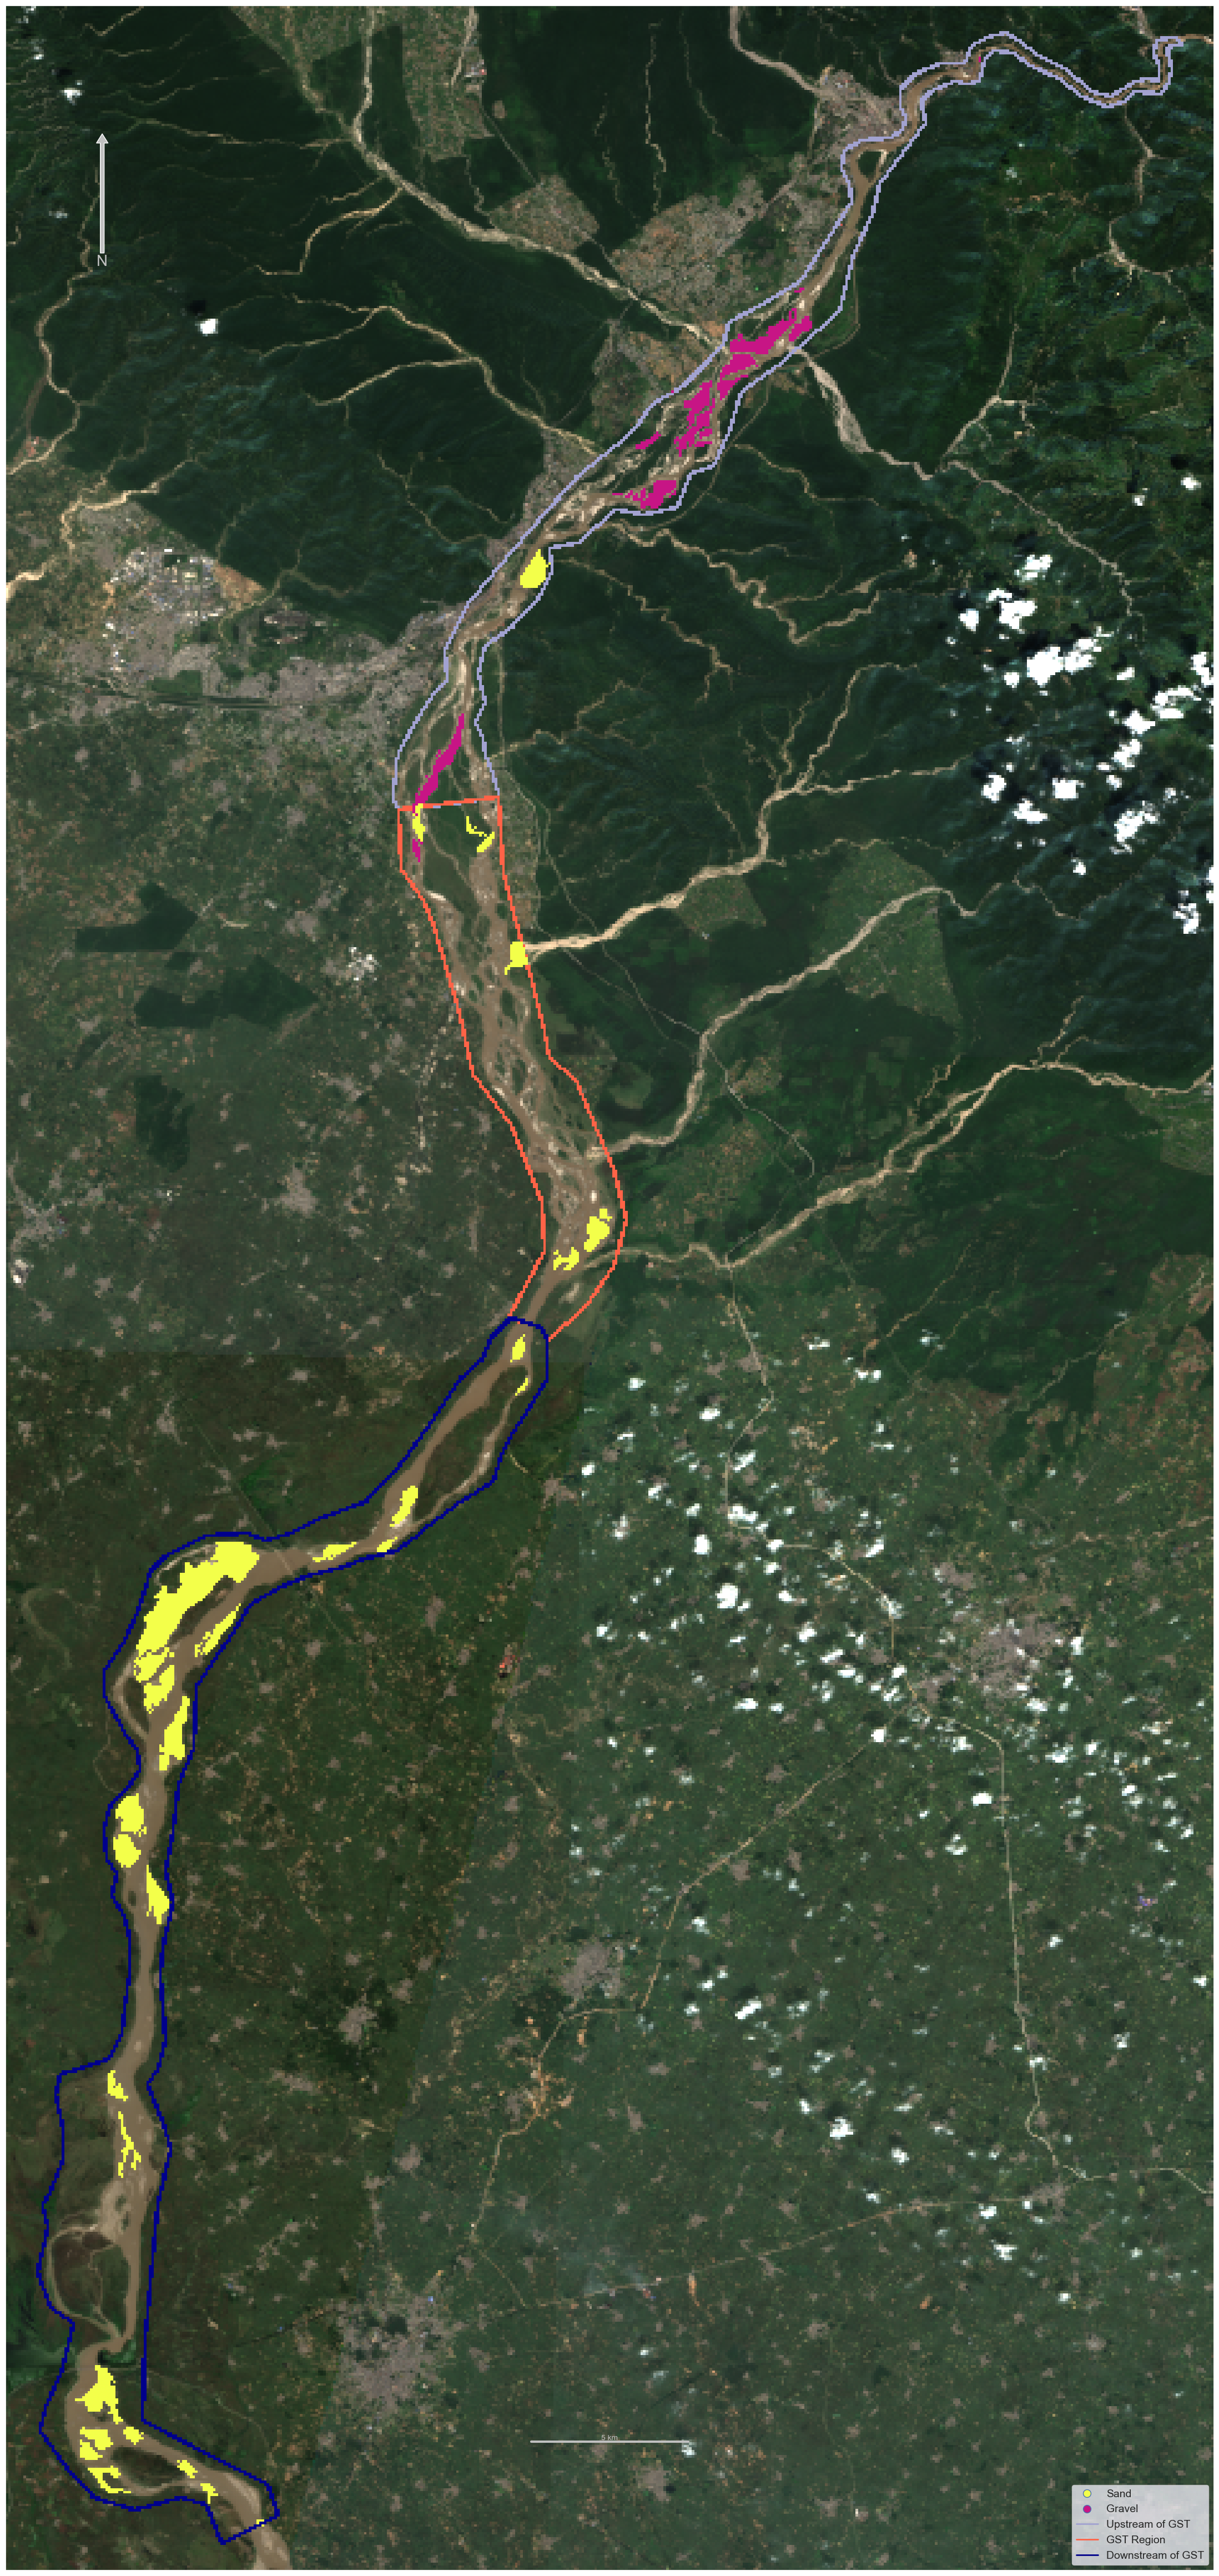

In [32]:
fig = plt.figure(figsize=(15, 30))

#Set full ROI first
bbox = roi.geometry().bounds().buffer(1000).bounds().getInfo()['coordinates'][0]
bbox = [bbox[0][0], bbox[0][1], bbox[2][0], bbox[2][1]] #snce you only need the corners
base = s1_s2.visualize(**qm.visParamsRGB)
#Add to map
ax = cartoee.get_map(base, region=bbox)

#Iterate over each section, classify and add to map
for i, r in enumerate([upper, gst, lower]):
    classy_region = classy_RF.clip(r).reproject (crs = classy_RF.projection(), scale = 10)

    sand_gravel = classy_RF.updateMask(classy_RF.eq(1).Or(classy_RF.eq(2))) 
    classesM = sand_gravel.visualize(**tv.classy_vizParams)
    cartoee.add_layer(ax, classesM, region=bbox)

    outline = empty.paint(featureCollection = r,
                            color= 1,
                            width= 1.5)
    style = region_styles[i]
    cartoee.add_layer(ax, outline.visualize(**style), region=bbox)

#Add legend
legend_elements = [
                Line2D([],[],marker="o",
                    markerfacecolor='#'+tv.palette[1],
                    label="Sand",
                    # markerfacecolor="#A8321D",
                    markersize=10,
                    ls=""),
                Line2D([],[],marker="o",
                    markerfacecolor='#'+tv.palette[2],
                    label="Gravel",
                    # markerfacecolor="#A8321D",
                    markersize=10,
                    ls=""),
                Line2D([], [], color=region_styles[0]['palette'], lw=2, label="Upstream of GST"),
                Line2D([], [], color=region_styles[1]['palette'], lw=2, label="GST Region"),
                Line2D([], [], color=region_styles[2]['palette'], lw=2, label="Downstream of GST")
                
            ]
legend = cartoee.add_legend(ax, legend_elements, loc='lower right')
cartoee.add_north_arrow(ax, arrow_color='#c0c0c0', text_color='#c0c0c0', xy=(0.08, 0.95), arrow_length=0.05)
# cartoee.add_scale_bar(ax, max_stripes=3, )
cartoee.add_scale_bar_lite(ax, xy=(0.5,0.05), fontsize=10, color='#c0c0c0')
# ax.set_title(fontsize=15)

# ax.coastlines()
plt.show()

### Full Classification Map

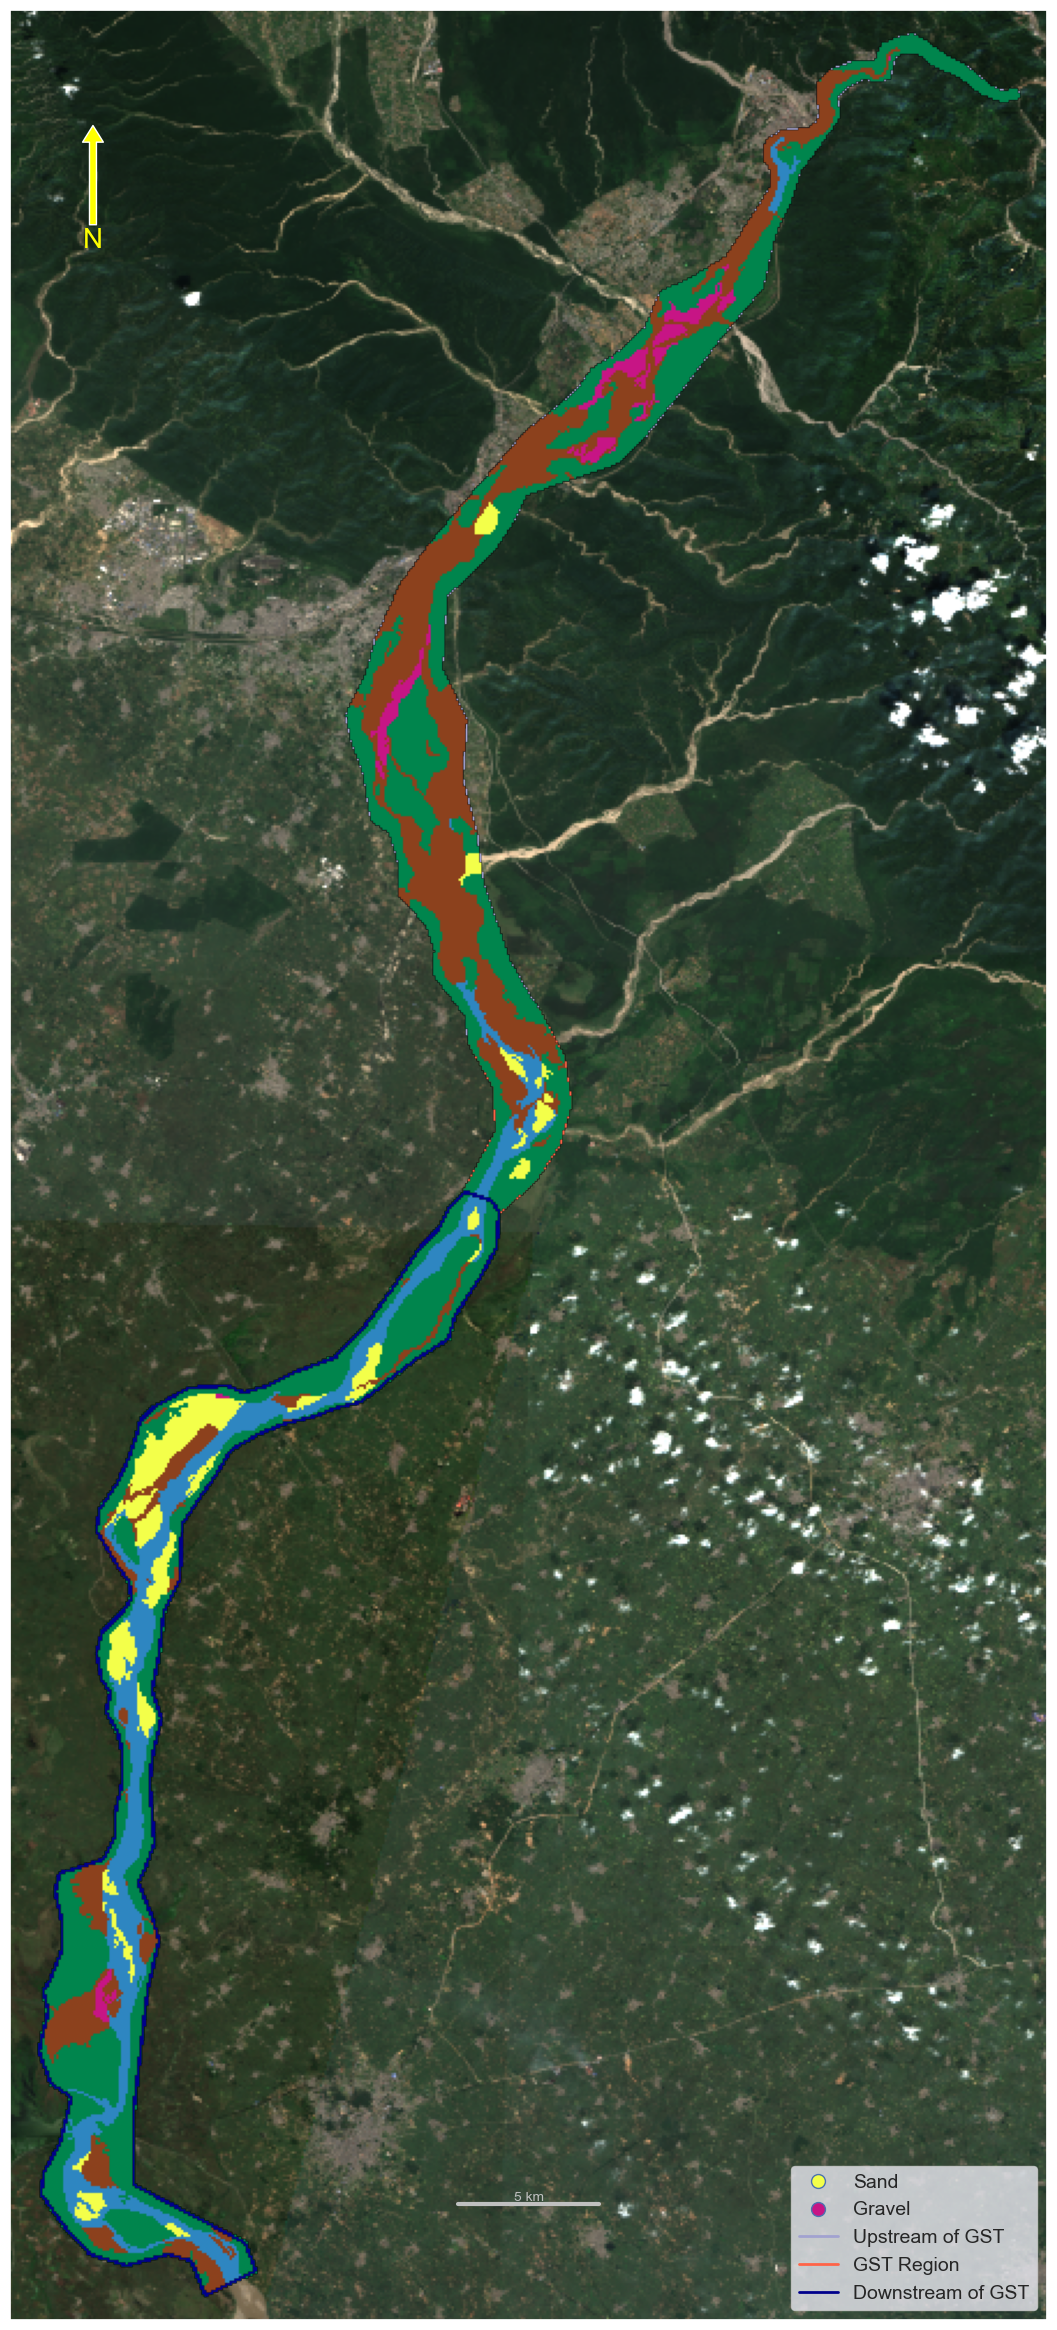

In [17]:
fig = plt.figure(figsize=(15, 30))

#Set full ROI first
bbox = roi.geometry().bounds().buffer(1000).bounds().getInfo()['coordinates'][0]
bbox = [bbox[0][0], bbox[0][1], bbox[2][0], bbox[2][1]] #snce you only need the corners
base = s1_s2.visualize(**qm.visParamsRGB)
#Add to map
ax = cartoee.get_map(base, region=bbox)

#Iterate over each section, classify and add to map
for i, r in enumerate([upper, gst, lower]):
    classy_region = classy_RF.clip(r).reproject (crs = classy_RF.projection(), scale = 10)

    # sand_gravel = classy_RF.updateMask(classy_RF.eq(1).Or(classy_RF.eq(2))) 
    classesM = classy_RF.visualize(**tv.classy_vizParams)
    cartoee.add_layer(ax, classesM, region=bbox)

    outline = empty.paint(featureCollection = r,
                            color= 1,
                            width= 1.5)
    style = region_styles[i]
    cartoee.add_layer(ax, outline.visualize(**style), region=bbox)

#Add legend
legend_elements = [
                Line2D([],[],marker="o",
                    markerfacecolor='#'+tv.palette[1],
                    label="Sand",
                    # markerfacecolor="#A8321D",
                    markersize=10,
                    ls=""),
                Line2D([],[],marker="o",
                    markerfacecolor='#'+tv.palette[2],
                    label="Gravel",
                    # markerfacecolor="#A8321D",
                    markersize=10,
                    ls=""),
                Line2D([], [], color=region_styles[0]['palette'], lw=2, label="Upstream of GST"),
                Line2D([], [], color=region_styles[1]['palette'], lw=2, label="GST Region"),
                Line2D([], [], color=region_styles[2]['palette'], lw=2, label="Downstream of GST")
                
            ]
legend = cartoee.add_legend(ax, legend_elements, loc='lower right')
cartoee.add_north_arrow(ax, arrow_color='yellow', text_color='yellow', xy=(0.08, 0.95), arrow_length=0.05)
# cartoee.add_scale_bar(ax, max_stripes=3, )
cartoee.add_scale_bar_lite(ax, xy=(0.5,0.05), fontsize=10, color='#c0c0c0')
# ax.set_title(fontsize=15)

# ax.coastlines()
plt.show()